# Selecionando Keywords

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

## SKU001 - Azul

In [2]:
SKU001_semana = pd.read_csv('semana.csv', skiprows=9, usecols=lambda column: column != '#')

In [3]:
# A observação 0 é a soma de tudo e deve ser removida.

SKU001_semana = SKU001_semana.drop(0)

Como na primeira semana venda alguma foi realizada e toda correspondência foi ampla, apenas as seguintes colunas são relevantes:
* Tipo de combinação
* Consulta de pesquisa
* Impressão
* Clique
* Despesas

In [4]:
SKU001_semana = SKU001_semana[['Consulta de pesquisa', 'Impressão', 'Cliques', 'Despesas']]

Pode ocorrer de uma mesma Consulta de pesquisa responda às duas Palavras-chave.

In [5]:
# Verificação de reincidência de consulta de pesquisa.

SKU001_semana['Consulta de pesquisa'].value_counts()

Consulta de pesquisa
blusa gola alta feminino              2
blusa caipira feminina                2
moletom feminino                      2
blusa malwee feminina                 2
cacharrel feminino lã                 2
                                     ..
Vest legging tricot colorida          1
Blusa manga longa malha               1
Blusa de lá aberta                    1
tricot feminino coração               1
camisa feminina manga longa xadrez    1
Name: count, Length: 14008, dtype: int64

In [6]:
# Diferença entre o total de item e o número de itens inéditos.
len(SKU001_semana) - len(SKU001_semana['Consulta de pesquisa'].value_counts())

71

In [7]:
# Agrupando pela Consulta de pesquisa e reiniciando o índice.
SKU001_semana = SKU001_semana.groupby('Consulta de pesquisa').agg({'Impressão': 'sum', 'Cliques': 'sum', 'Despesas': 'sum'}).reset_index()

O CTR será calculado a partir dos valores somados.

In [8]:
SKU001_semana['CTR'] = SKU001_semana['Cliques']/SKU001_semana['Impressão']

O custo do clique não é, necessariamente, o valor máximo do lance. Devido a isso, uma nova coluna será criada, mostrando o custo médio dos cliques.

In [9]:
SKU001_semana['Custo Médio'] = SKU001_semana['Despesas']/SKU001_semana['Cliques']

In [10]:
# Ambas as divisões por zero podem criar valores nan.

SKU001_semana.fillna(0,inplace=True)

In [11]:
SKU001_semana.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14008 entries, 0 to 14007
Data columns (total 6 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Consulta de pesquisa  14008 non-null  object 
 1   Impressão             14008 non-null  int64  
 2   Cliques               14008 non-null  int64  
 3   Despesas              14008 non-null  float64
 4   CTR                   14008 non-null  float64
 5   Custo Médio           14008 non-null  float64
dtypes: float64(3), int64(2), object(1)
memory usage: 656.8+ KB


Os valores de CTR devem estar em float ao invés de string. O CTR pode ser recalculado dividindo Cliques por Impressões, ou os valores podem ser modificados a partir de como estão.

In [12]:
# SKU001_semana['CTR'] = SKU001_semana['CTR'].str.rstrip('%').astype(float)

In [13]:
SKU001_semana.head()

,Consulta de pesquisa,Impressão,Cliques,Despesas,CTR,Custo Médio
0,0Blusa Feminina Suéter Poncho Modal,1,0,0.0,0.0,0.0
1,0Blusa Feminina Tricot Manga Longa Colmeia Ond...,2,0,0.0,0.0,0.0
2,2023 blusas arrumada,1,0,0.0,0.0,0.0
3,3 croppeds,1,0,0.0,0.0,0.0
4,3rd fashion,2,0,0.0,0.0,0.0


In [14]:
SKU001_semana.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14008 entries, 0 to 14007
Data columns (total 6 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Consulta de pesquisa  14008 non-null  object 
 1   Impressão             14008 non-null  int64  
 2   Cliques               14008 non-null  int64  
 3   Despesas              14008 non-null  float64
 4   CTR                   14008 non-null  float64
 5   Custo Médio           14008 non-null  float64
dtypes: float64(3), int64(2), object(1)
memory usage: 656.8+ KB


### Melhores Palavras-chave

### Função

In [15]:
def pareto(df, column, crit, method = 'eff', graph = False):
    df_organizado = df.sort_values(column, ascending=False)
    if method == 'eff':
        Crit = df_organizado[column].sum() * crit
        df_organizado['Pareto '+column] = df_organizado[column].cumsum()
        df_organizado = df_organizado.drop(df_organizado[df_organizado['Pareto '+column] > Crit].index)
        print('Percentual de itens remanecentes:', (len(df_organizado) / len(df)))
        print('            Tamanho do dataframe:', len(df_organizado))
    elif method == 'items':
        Crit = round(len(df_organizado) * crit)
        df_organizado = df_organizado.head(Crit)
        df_organizado['Pareto '+column] = df_organizado[column].cumsum()
        print('                     Efetividade:', (df_organizado['Pareto '+column].iloc[-1] / df[column].sum()))
        print('            Tamanho do dataframe:', len(df_organizado))
    elif method == 'num':
        Crit = crit
        print(Crit)
        df_organizado = df_organizado.head(Crit)
        df_organizado['Pareto '+column] = df_organizado[column].cumsum()
        print('                     Efetividade:', (df_organizado['Pareto '+column].iloc[-1] / df[column].sum()))
        print('Percentual de itens remanecentes:', (len(df_organizado) / len(df)))
    
    if graph:
        plt.figure(figsize=(19, 6))
        ax = sns.barplot(x='Consulta de pesquisa', y=column, data=df_organizado)
        sns.despine()
        if len(df_organizado) > 61:
            ax.set_xticks([])
        else:
            plt.xticks(rotation=90)
    return df_organizado

In [16]:
def aproveitamento(df_result,df_orign,column):
    print('Efetividade:', (df_result[column].sum() / df_orign[column].sum()))

In [17]:
def plot_bar(Y,Dados,Método):
    plt.figure(figsize=(19, 6))
    ax = sns.barplot(x='Consulta de pesquisa', y=Y, data=Dados.sort_values(Y, ascending=False))
    sns.despine()
    plt.xticks(rotation=90)

    ax.set_yticklabels([])
    for p in ax.patches:
        valor = p.get_height()
        if Dados[Y].dtype == np.int64:
            texto_valor = format(valor, '.0f')
        else:
            texto_valor = format(valor, '.2f')
        ax.annotate(texto_valor,
                    (p.get_x() + p.get_width() / 2., p.get_height()),
                    ha='center', va='center', xytext=(0, 5), textcoords='offset points')

    ax.set_title(Método, fontsize=17)

    plt.savefig(Método+'_'+Y+'.png', dpi=300, bbox_inches='tight')
    
    #ax.annotate(Método, (10, 400),xytext=(10, 400),ha='center', va='center', fontsize=20)

**MESCA DE IMPRESSÕES, CLIQUES E CTR**

100 maiores impressões, 50 mais clicados, 20 maiores CTRs.

In [18]:
SKU001_MesclaA = pareto(SKU001_semana, 'Impressão', 100, method = 'num')
SKU001_MesclaA = pareto(SKU001_MesclaA, 'Cliques', 50, method = 'num')
SKU001_MesclaA = pareto(SKU001_MesclaA, 'CTR', 20, method = 'num')

100
                     Efetividade: 0.2582163618318446
Percentual de itens remanecentes: 0.007138777841233581
50
                     Efetividade: 0.9556962025316456
Percentual de itens remanecentes: 0.5
20
                     Efetividade: 0.6495297540976368
Percentual de itens remanecentes: 0.4


In [19]:
SKU001_MesclaA

,Consulta de pesquisa,Impressão,Cliques,Despesas,CTR,Custo Médio,Pareto Impressão,Pareto Cliques,Pareto CTR
9831,blusa modal feminino,47,4,0.44,0.085106,0.11,7590,82,0.085106
8470,blusa de pelinho feminina,45,3,0.33,0.066667,0.11,7681,94,0.151773
6558,Sueter Feminino,94,6,0.66,0.063830,0.11,5284,57,0.215603
10437,blusa tricot,32,2,0.22,0.062500,0.11,9011,118,0.278103
9335,blusa frio feminina,33,2,0.22,0.060606,0.11,8882,116,0.338709
8266,blusa de linho,33,2,0.22,0.060606,0.11,8849,114,0.399315
4664,Brechó,50,3,0.33,0.060000,0.11,7401,91,0.459315
8343,blusa de lã feminina plus size,34,2,0.22,0.058824,0.11,8682,110,0.518138
12202,cardigan tricot,54,3,0.33,0.055556,0.11,7247,88,0.573694
6965,Tricô,38,2,0.22,0.052632,0.11,8250,106,0.626326


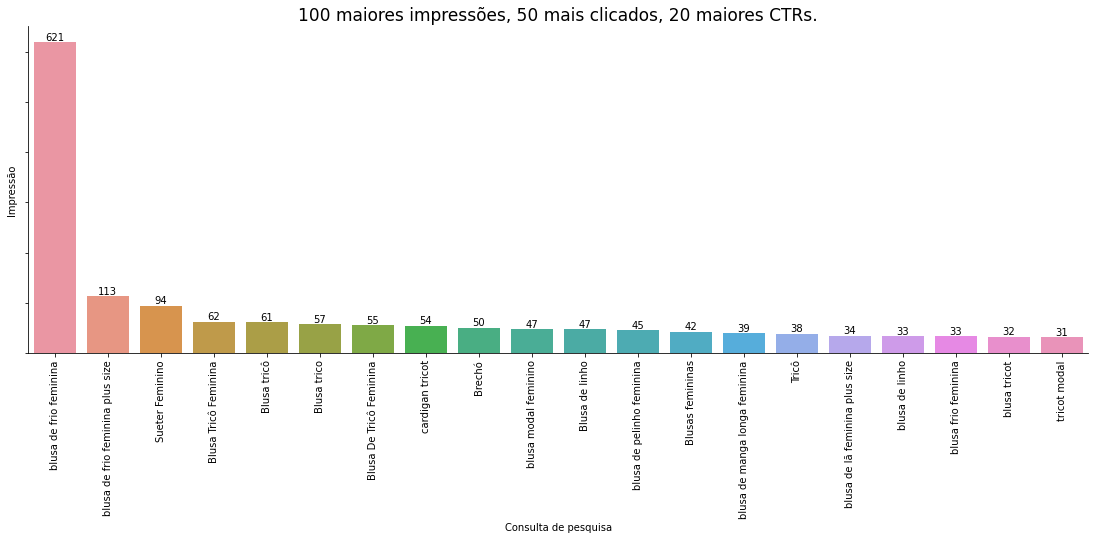

In [20]:
plot_bar('Impressão',SKU001_MesclaA,'100 maiores impressões, 50 mais clicados, 20 maiores CTRs.')

In [21]:
aproveitamento(SKU001_MesclaA,SKU001_semana,'Impressão')

Efetividade: 0.04503048348220615


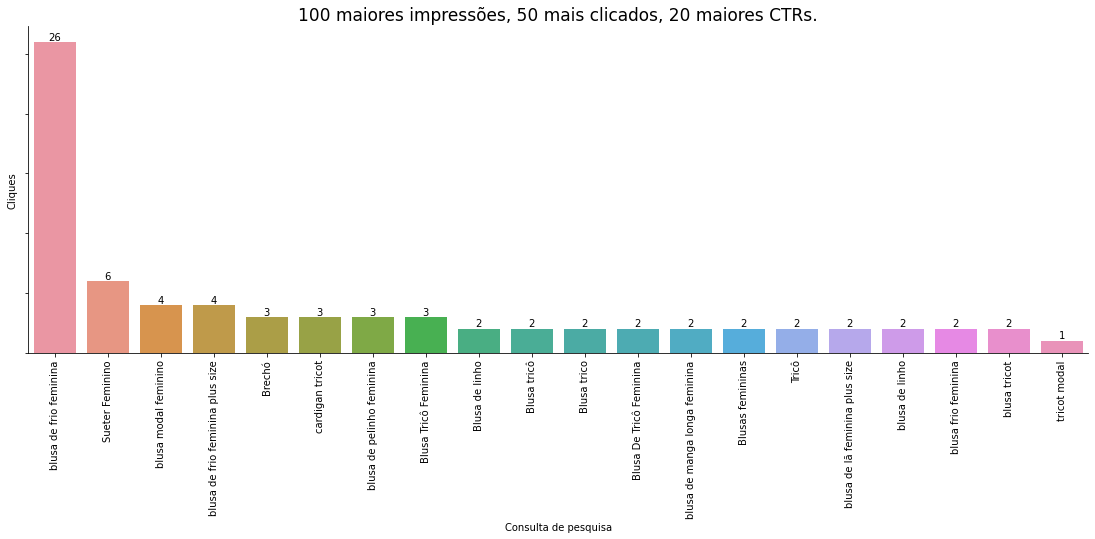

In [22]:
plot_bar('Cliques',SKU001_MesclaA,'100 maiores impressões, 50 mais clicados, 20 maiores CTRs.')

In [23]:
aproveitamento(SKU001_MesclaA,SKU001_semana,'Cliques')

Efetividade: 0.14423076923076922


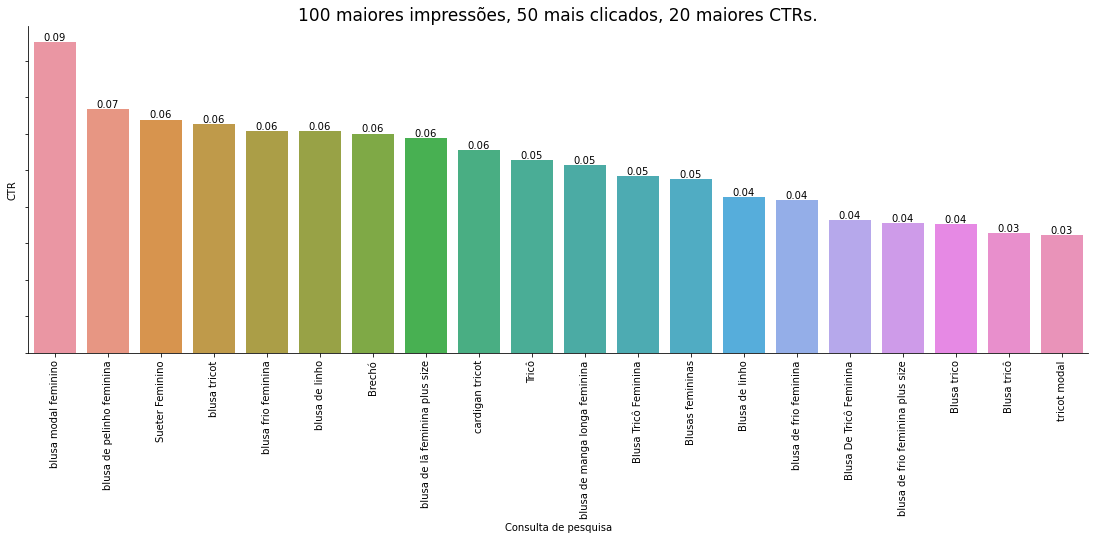

In [24]:
plot_bar('CTR',SKU001_MesclaA,'100 maiores impressões, 50 mais clicados, 20 maiores CTRs.')

100 maiores impressões, 50 maiores CTRs, 20 mais clicados.

In [25]:
SKU001_MesclaB = pareto(SKU001_semana, 'Impressão', 100, method = 'num')
SKU001_MesclaB = pareto(SKU001_MesclaB, 'CTR', 50, method = 'num')
SKU001_MesclaB = pareto(SKU001_MesclaB, 'Cliques', 20, method = 'num')

100
                     Efetividade: 0.2582163618318446
Percentual de itens remanecentes: 0.007138777841233581
50
                     Efetividade: 0.9669258904054271
Percentual de itens remanecentes: 0.5
20
                     Efetividade: 0.7094594594594594
Percentual de itens remanecentes: 0.4


In [26]:
SKU001_MesclaB

,Consulta de pesquisa,Impressão,Cliques,Despesas,CTR,Custo Médio,Pareto Impressão,Pareto CTR,Pareto Cliques
8000,blusa de frio feminina,621,26,2.86,0.041868,0.11,621,0.858035,26
8315,blusa de lã feminina,351,11,1.21,0.031339,0.11,1956,1.061269,37
8592,blusa de tricô feminina,280,7,0.77,0.025000,0.11,2573,1.259129,44
8846,blusa feminina,337,7,0.77,0.020772,0.11,2293,1.414551,51
6558,Sueter Feminino,94,6,0.66,0.063830,0.11,5284,0.215603,57
268,Blusa De Frio Feminina,221,5,0.55,0.022624,0.11,3532,1.351820,62
10465,blusa tricot feminino,266,4,0.44,0.015038,0.11,2839,1.605515,66
12175,cardigan feminino,241,4,0.44,0.016598,0.11,3080,1.559700,70
8073,blusa de frio feminina plus size,113,4,0.44,0.035398,0.11,4875,0.929797,74
13736,tricot feminino,170,4,0.44,0.023529,0.11,4054,1.306468,78


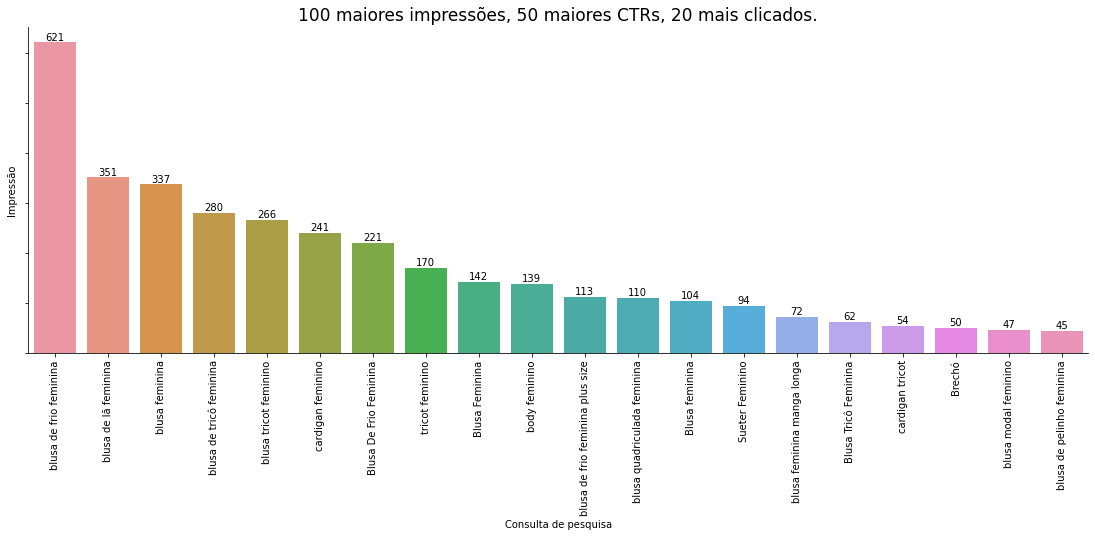

In [27]:
plot_bar('Impressão',SKU001_MesclaB,'100 maiores impressões, 50 maiores CTRs, 20 mais clicados.')

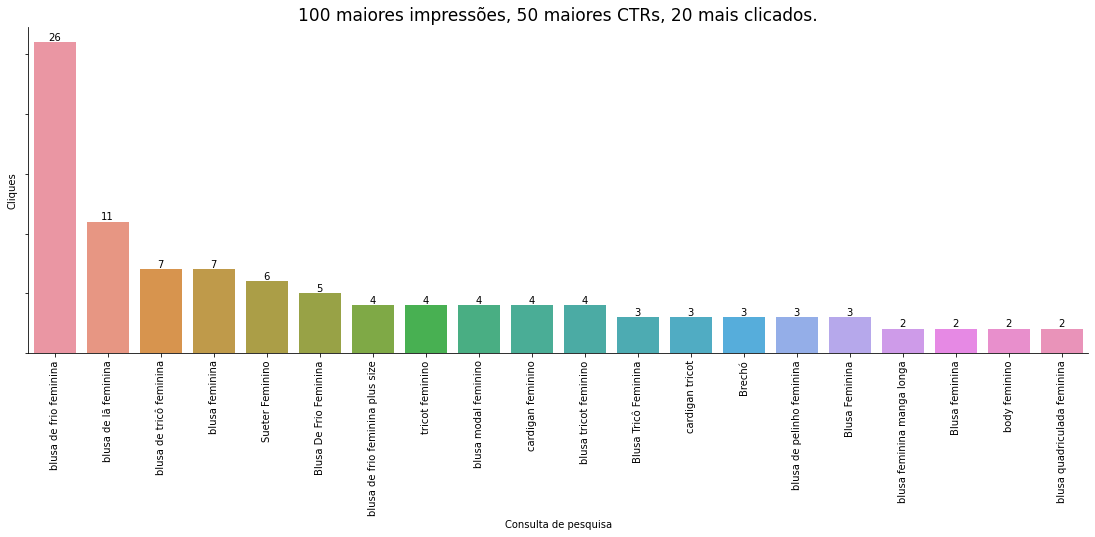

In [28]:
plot_bar('Cliques',SKU001_MesclaB,'100 maiores impressões, 50 maiores CTRs, 20 mais clicados.')

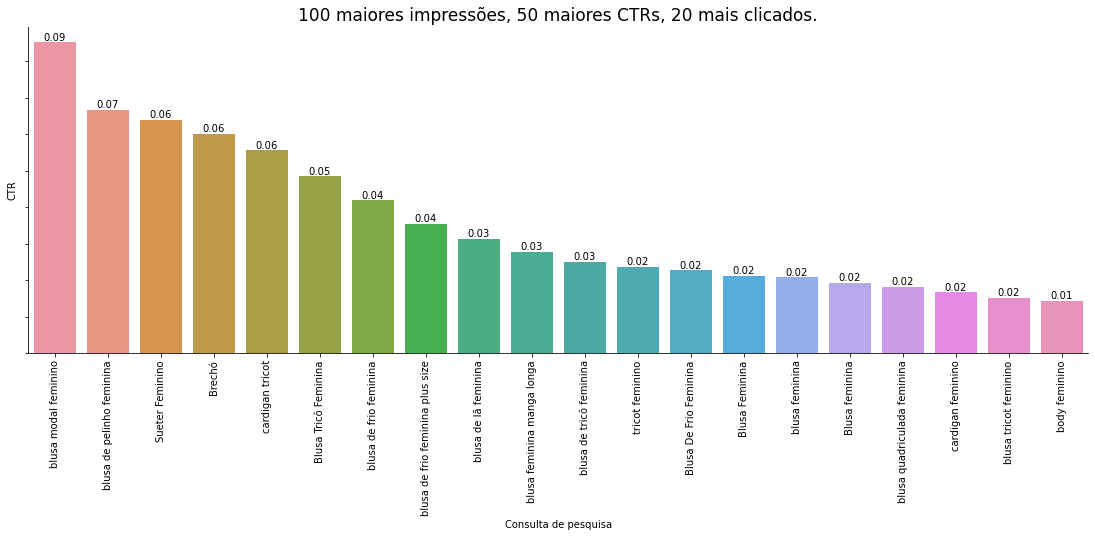

In [29]:
plot_bar('CTR',SKU001_MesclaB,'100 maiores impressões, 50 maiores CTRs, 20 mais clicados.')

100 mais clicados, 50 maiores CTRs, 20 maiores impressões.

In [30]:
SKU001_MesclaC = pareto(SKU001_semana, 'Cliques', 100, method = 'num')
SKU001_MesclaC = pareto(SKU001_MesclaC, 'CTR', 50, method = 'num')
SKU001_MesclaC = pareto(SKU001_MesclaC, 'Impressão', 20, method = 'num')

100
                     Efetividade: 0.45
Percentual de itens remanecentes: 0.007138777841233581
50
                     Efetividade: nan
Percentual de itens remanecentes: 0.5
20
                     Efetividade: 0.7839721254355401
Percentual de itens remanecentes: 0.4


C:\Users\fnsb\AppData\Local\Temp\ipykernel_20604\85931560.py:20: RuntimeWarning: invalid value encountered in double_scalars
  print('                     Efetividade:', (df_organizado['Pareto '+column].iloc[-1] / df[column].sum()))


In [31]:
SKU001_MesclaC

,Consulta de pesquisa,Impressão,Cliques,Despesas,CTR,Custo Médio,Pareto Cliques,Pareto CTR,Pareto Impressão
9804,blusa meia estação feminina,25,4,0.44,0.160000,0.11,74,inf,25
8999,blusa feminina de tricô,19,2,0.22,0.105263,0.11,128,inf,44
1707,Blusa de tricô feminina,19,2,0.22,0.105263,0.11,182,inf,63
13937,tricô plus size,19,3,0.33,0.157895,0.11,104,inf,82
5258,Cardigan Feminino Trico,17,2,0.22,0.117647,0.11,174,inf,99
9647,blusa manga comprida feminina,15,2,0.22,0.133333,0.11,124,inf,114
399,Blusa Julia,10,1,0.11,0.100000,0.11,224,inf,124
3907,Blusas de tricô,10,2,0.22,0.200000,0.11,132,inf,134
13244,moletom feminino,9,2,0.22,0.222222,0.11,194,inf,143
7891,blusa de crochê,9,1,0.11,0.111111,0.11,234,inf,152


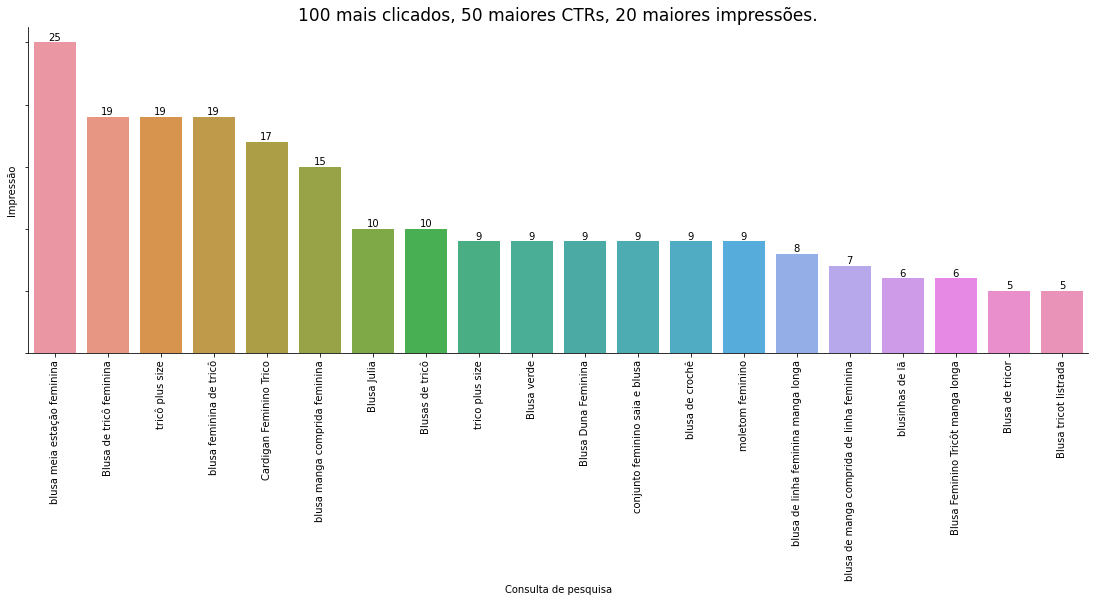

In [32]:
plot_bar('Impressão',SKU001_MesclaC,'100 mais clicados, 50 maiores CTRs, 20 maiores impressões.')

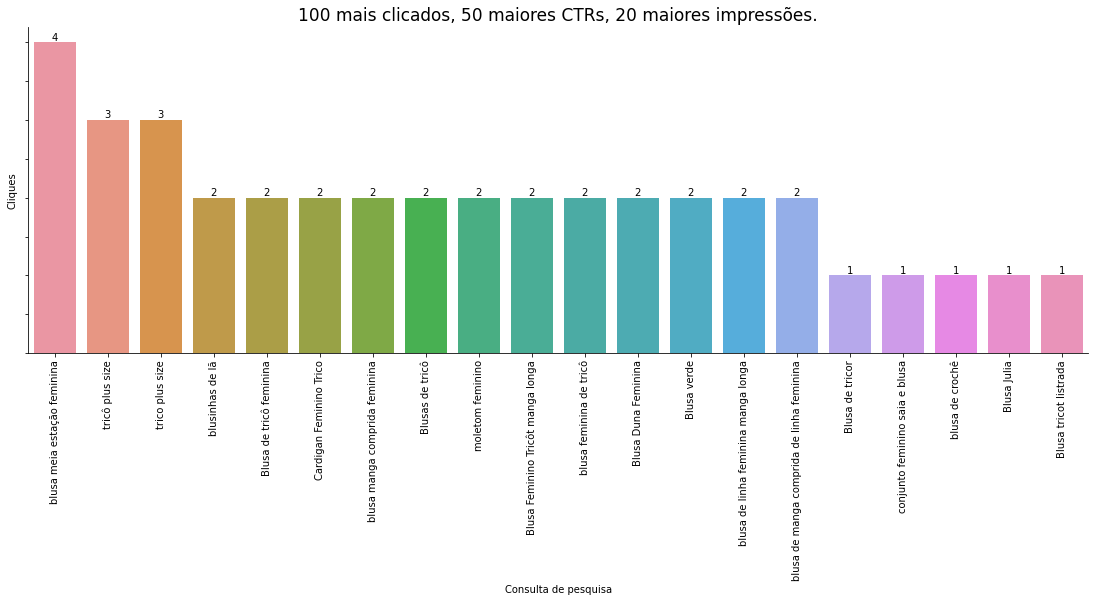

In [33]:
plot_bar('Cliques',SKU001_MesclaC,'100 mais clicados, 50 maiores CTRs, 20 maiores impressões.')

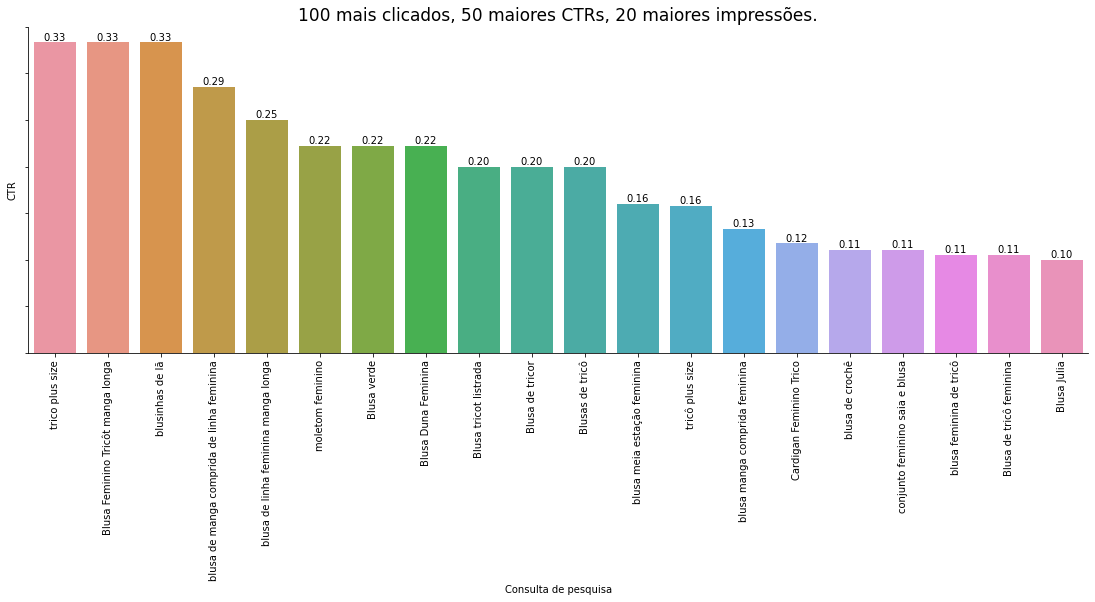

In [34]:
plot_bar('CTR',SKU001_MesclaC,'100 mais clicados, 50 maiores CTRs, 20 maiores impressões.')

100 mais clicados, 50 maiores impressões, 20 maiores CTRs.

In [35]:
SKU001_MesclaD = pareto(SKU001_semana, 'Cliques', 100, method = 'num')
SKU001_MesclaD = pareto(SKU001_MesclaD, 'Impressão', 50, method = 'num')
SKU001_MesclaD = pareto(SKU001_MesclaD, 'CTR', 20, method = 'num')

100
                     Efetividade: 0.45
Percentual de itens remanecentes: 0.007138777841233581
50
                     Efetividade: 0.952260397830018
Percentual de itens remanecentes: 0.5
20
                     Efetividade: 0.6634741357175732
Percentual de itens remanecentes: 0.4


In [36]:
SKU001_MesclaD

,Consulta de pesquisa,Impressão,Cliques,Despesas,CTR,Custo Médio,Pareto Cliques,Pareto Impressão,Pareto CTR
9804,blusa meia estação feminina,25,4,0.44,0.160000,0.11,74,5018,0.160000
13937,tricô plus size,19,3,0.33,0.157895,0.11,104,5247,0.317895
1707,Blusa de tricô feminina,19,2,0.22,0.105263,0.11,182,5266,0.423158
8999,blusa feminina de tricô,19,2,0.22,0.105263,0.11,128,5228,0.528421
6302,Modal,20,2,0.22,0.100000,0.11,154,5189,0.628421
9828,blusa modal,20,2,0.22,0.100000,0.11,144,5169,0.728421
10202,blusa segunda pele feminino,21,2,0.22,0.095238,0.11,112,5149,0.823659
8256,blusa de linha feminina,22,2,0.22,0.090909,0.11,114,5085,0.914568
7191,bazar feminino brecho,22,2,0.22,0.090909,0.11,140,5063,1.005477
9450,blusa inverno feminina,23,2,0.22,0.086957,0.11,188,5041,1.092434


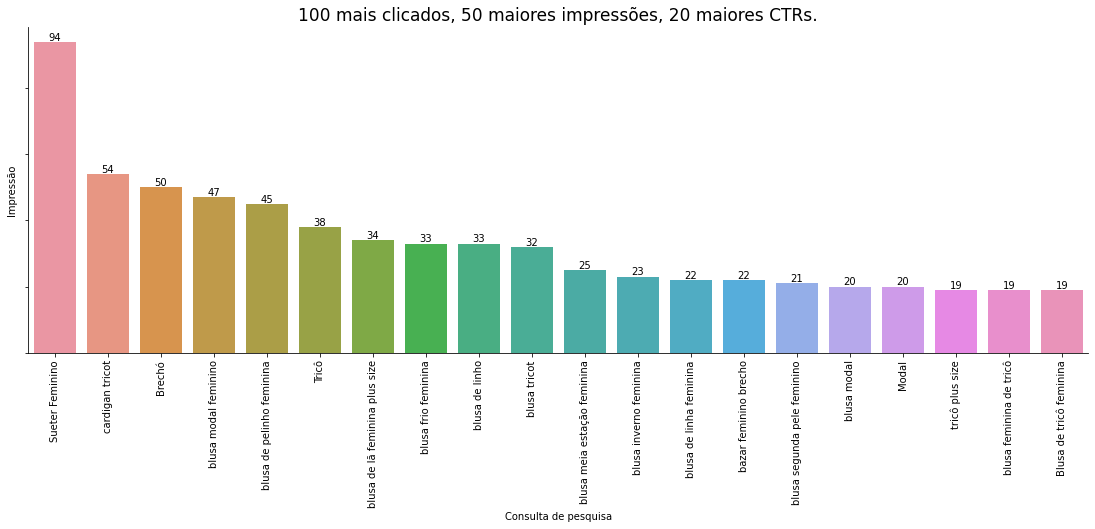

In [37]:
plot_bar('Impressão',SKU001_MesclaD,'100 mais clicados, 50 maiores impressões, 20 maiores CTRs.')

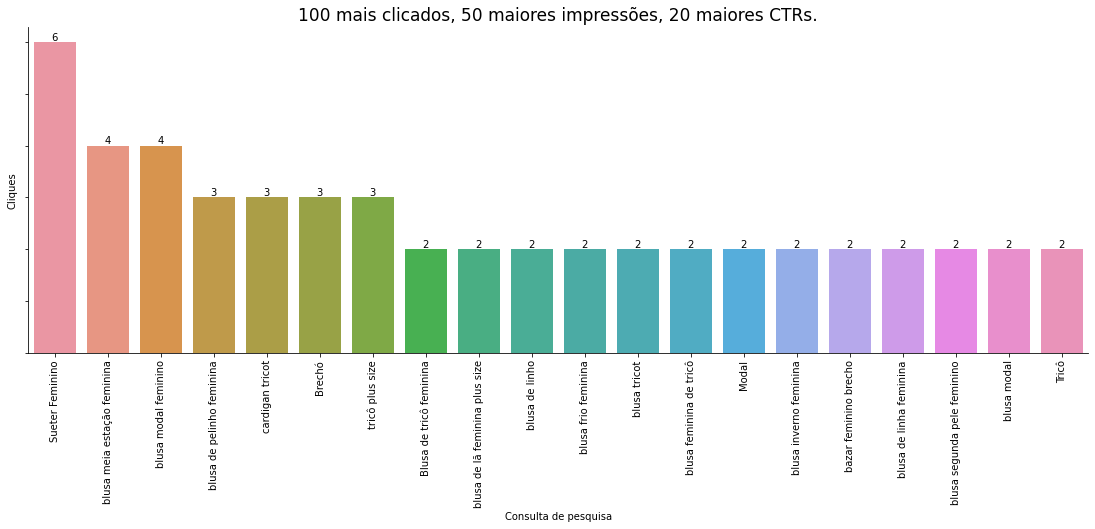

In [38]:
plot_bar('Cliques',SKU001_MesclaD,'100 mais clicados, 50 maiores impressões, 20 maiores CTRs.')

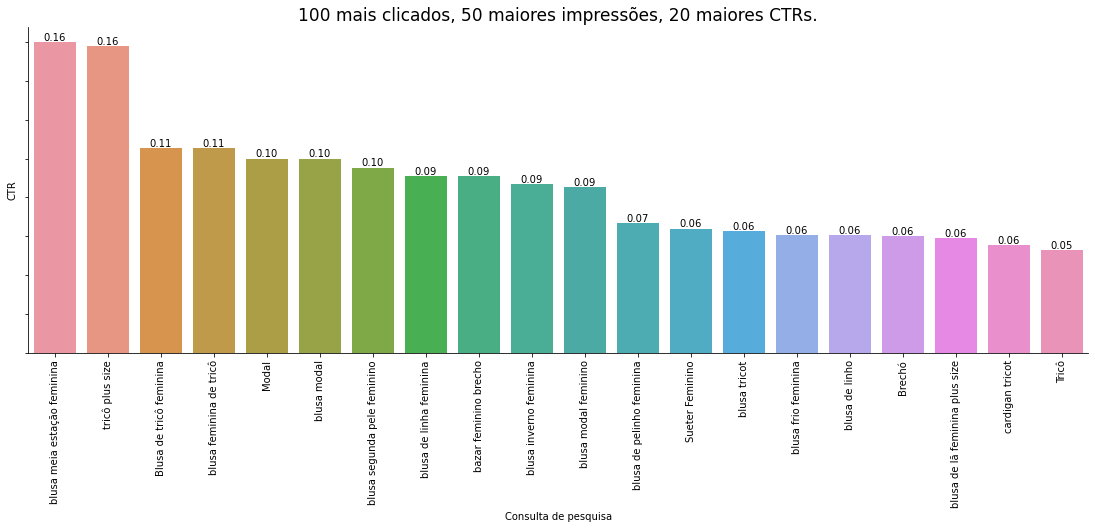

In [39]:
plot_bar('CTR',SKU001_MesclaD,'100 mais clicados, 50 maiores impressões, 20 maiores CTRs.')

100 maiores CTRs, 50 maiores impressões, 20 mais clicados.

In [40]:
SKU001_MesclaE = pareto(SKU001_semana, 'CTR', 100, method = 'num')
SKU001_MesclaE = pareto(SKU001_MesclaE, 'Impressão', 50, method = 'num')
SKU001_MesclaE = pareto(SKU001_MesclaE, 'Cliques', 20, method = 'num')

100
                     Efetividade: nan
Percentual de itens remanecentes: 0.007138777841233581
50
                     Efetividade: 0.6858974358974359
Percentual de itens remanecentes: 0.5
20
                     Efetividade: 0.4444444444444444
Percentual de itens remanecentes: 0.4


C:\Users\fnsb\AppData\Local\Temp\ipykernel_20604\85931560.py:20: RuntimeWarning: invalid value encountered in double_scalars
  print('                     Efetividade:', (df_organizado['Pareto '+column].iloc[-1] / df[column].sum()))


In [41]:
SKU001_MesclaE

,Consulta de pesquisa,Impressão,Cliques,Despesas,CTR,Custo Médio,Pareto CTR,Pareto Impressão,Pareto Cliques
3290,Blusa tricot de linha,4,2,0.22,0.500000,0.11,inf,4,2
8882,blusa feminina basica manga longa,3,2,0.22,0.666667,0.11,inf,15,4
6468,Roupa feminina de inverno,4,2,0.22,0.500000,0.11,inf,8,6
11245,blusinhas de verão feminina,4,2,0.22,0.500000,0.11,inf,12,8
8798,blusa envangelico,2,1,0.11,0.500000,0.11,inf,83,9
1494,Blusa de manga de tri or,2,1,0.11,0.500000,0.11,inf,65,10
5035,Camisa manga longa duna,2,1,0.11,0.500000,0.11,inf,67,11
10471,blusa tricot feminino azul marinho,2,1,0.11,0.500000,0.11,inf,69,12
612,Blusa alongada,2,1,0.11,0.500000,0.11,inf,71,13
1045,Blusa d linho,2,1,0.11,0.500000,0.11,inf,73,14


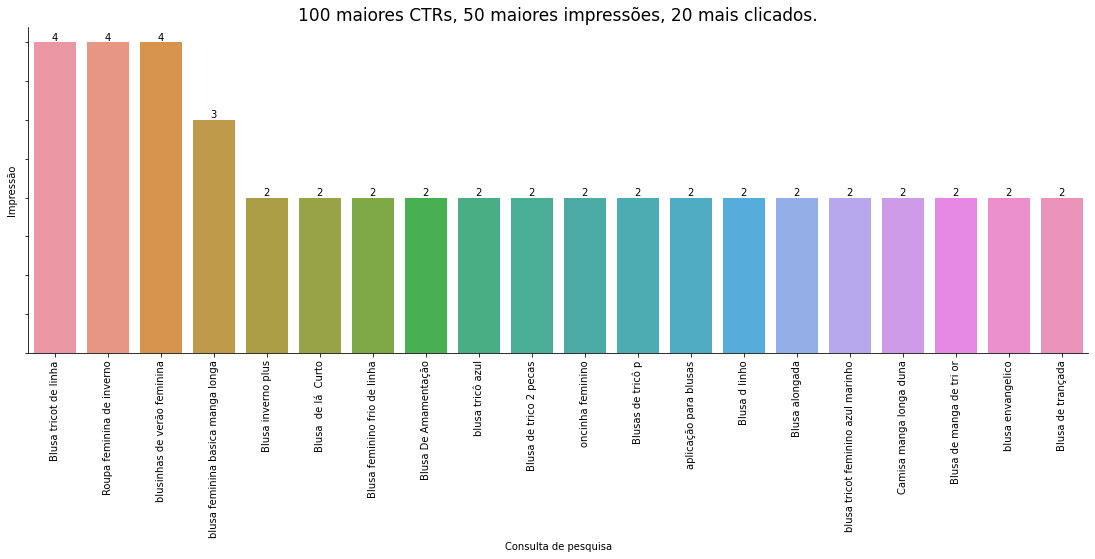

In [42]:
plot_bar('Impressão',SKU001_MesclaE,'100 maiores CTRs, 50 maiores impressões, 20 mais clicados.')

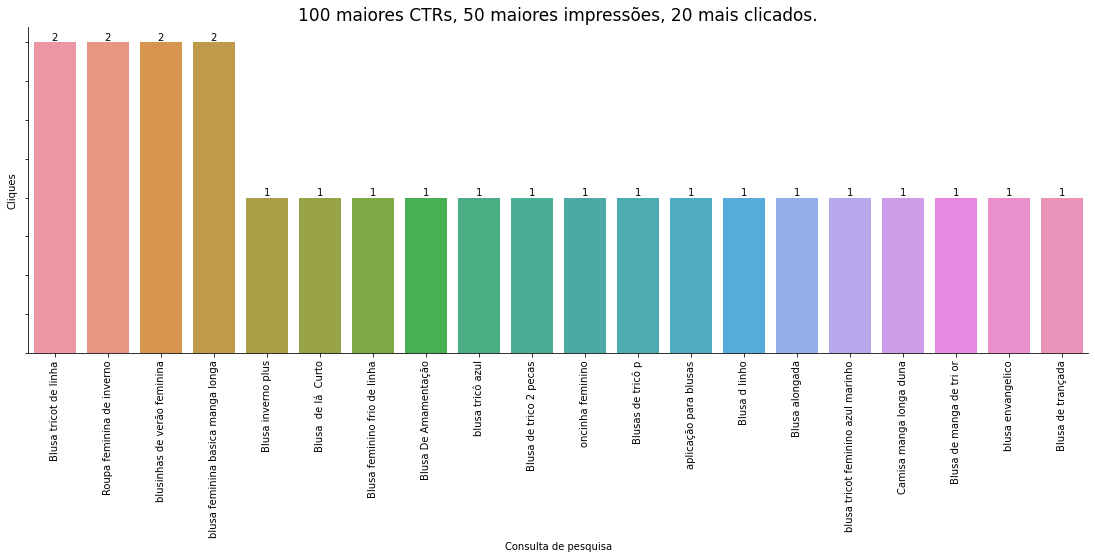

In [43]:
plot_bar('Cliques',SKU001_MesclaE,'100 maiores CTRs, 50 maiores impressões, 20 mais clicados.')

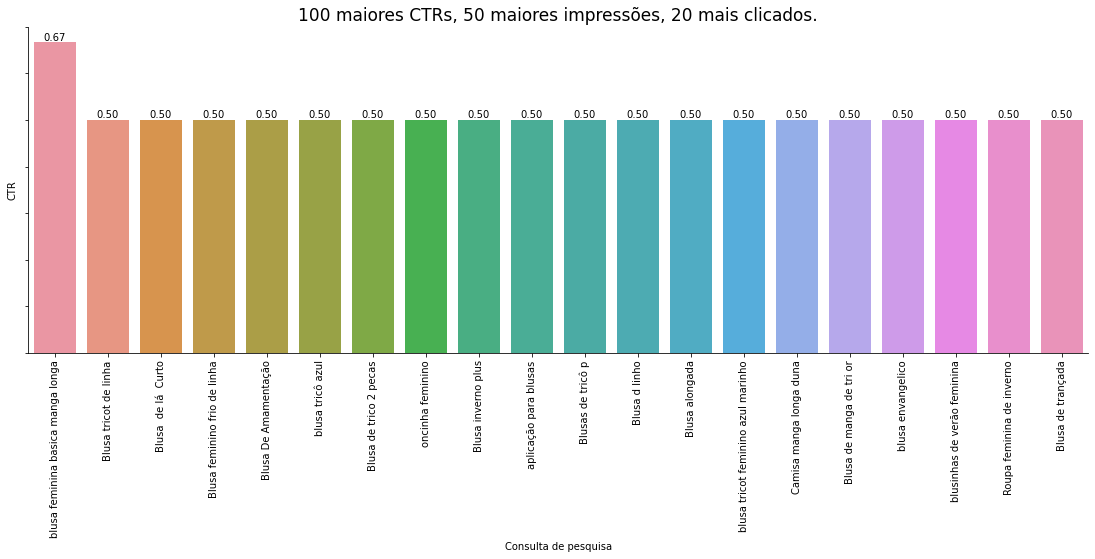

In [44]:
plot_bar('CTR',SKU001_MesclaE,'100 maiores CTRs, 50 maiores impressões, 20 mais clicados.')

100 maiores CTRs, 50 mais clicados, 20 maiores impressões.

In [45]:
SKU001_MesclaF = pareto(SKU001_semana, 'CTR', 100, method = 'num')
SKU001_MesclaF = pareto(SKU001_MesclaF, 'Cliques', 50, method = 'num')
SKU001_MesclaF = pareto(SKU001_MesclaF, 'Impressão', 20, method = 'num')

100
                     Efetividade: nan
Percentual de itens remanecentes: 0.007138777841233581
50
                     Efetividade: 0.5327102803738317
Percentual de itens remanecentes: 0.5
20
                     Efetividade: 0.4563106796116505
Percentual de itens remanecentes: 0.4


C:\Users\fnsb\AppData\Local\Temp\ipykernel_20604\85931560.py:20: RuntimeWarning: invalid value encountered in double_scalars
  print('                     Efetividade:', (df_organizado['Pareto '+column].iloc[-1] / df[column].sum()))


In [46]:
SKU001_MesclaF

,Consulta de pesquisa,Impressão,Cliques,Despesas,CTR,Custo Médio,Pareto CTR,Pareto Cliques,Pareto Impressão
3290,Blusa tricot de linha,4,2,0.22,0.500000,0.11,inf,4,4
6468,Roupa feminina de inverno,4,2,0.22,0.500000,0.11,inf,10,8
11245,blusinhas de verão feminina,4,2,0.22,0.500000,0.11,inf,14,12
8882,blusa feminina basica manga longa,3,2,0.22,0.666667,0.11,inf,12,15
5738,Croped medio,2,2,0.22,1.000000,0.11,inf,2,17
13255,oncinha feminino,2,1,0.11,0.500000,0.11,inf,46,19
2990,Blusa que vira colete,2,1,0.11,0.500000,0.11,inf,37,21
1608,Blusa de trico 2 pecas,2,1,0.11,0.500000,0.11,inf,38,23
5035,Camisa manga longa duna,2,1,0.11,0.500000,0.11,inf,39,25
10471,blusa tricot feminino azul marinho,2,1,0.11,0.500000,0.11,inf,40,27


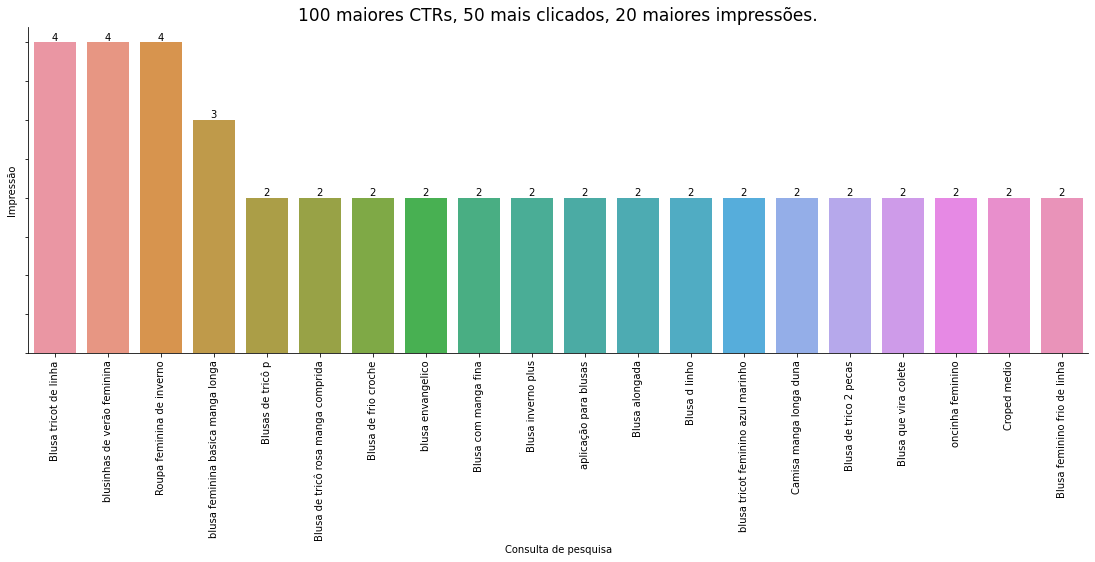

In [47]:
plot_bar('Impressão',SKU001_MesclaF,'100 maiores CTRs, 50 mais clicados, 20 maiores impressões.')

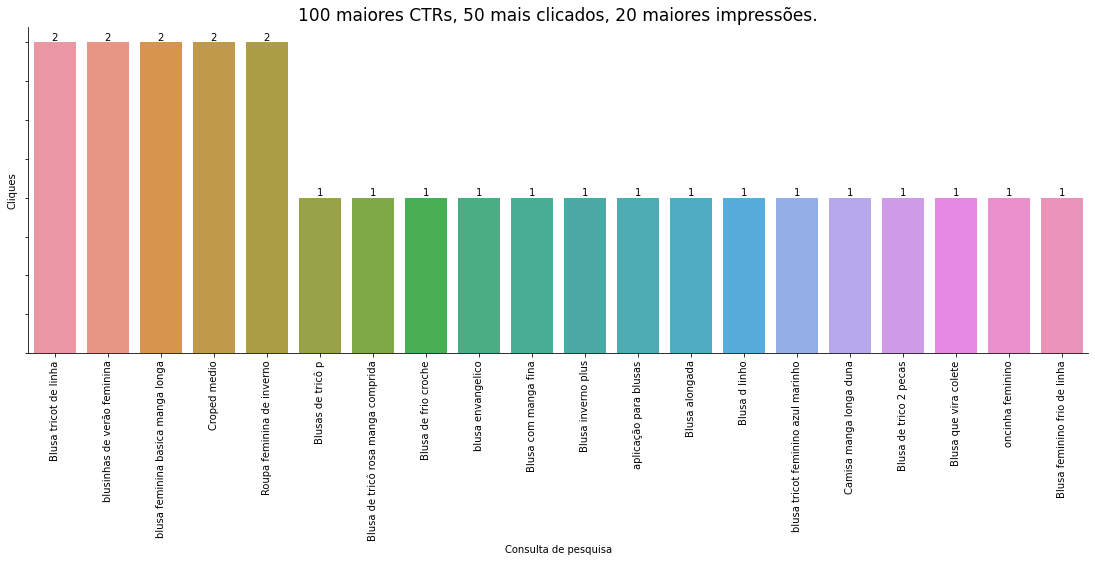

In [48]:
plot_bar('Cliques',SKU001_MesclaF,'100 maiores CTRs, 50 mais clicados, 20 maiores impressões.')

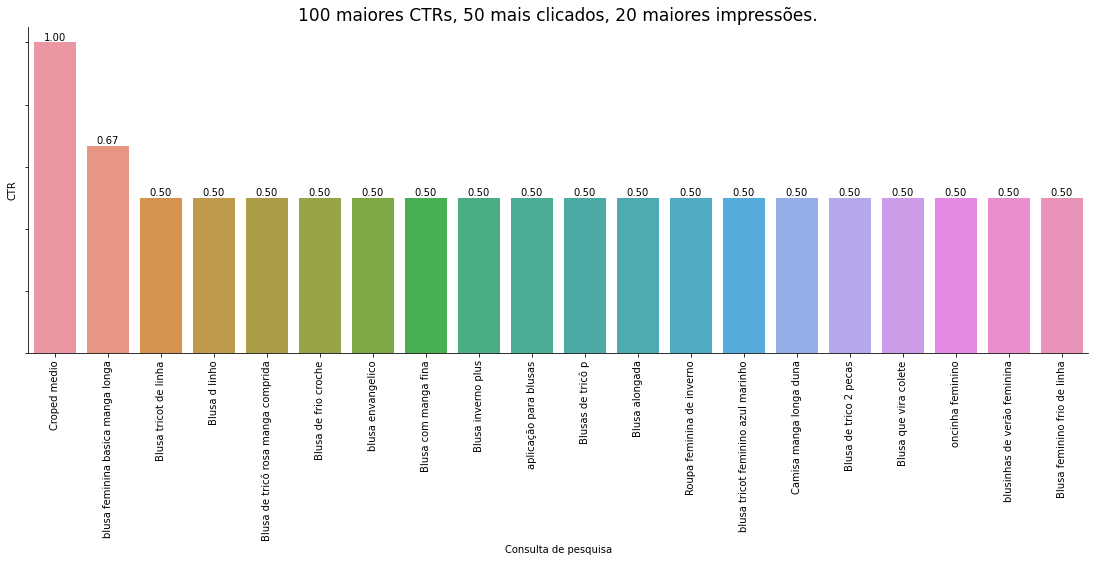

In [49]:
plot_bar('CTR',SKU001_MesclaF,'100 maiores CTRs, 50 mais clicados, 20 maiores impressões.')

### Efetividade

In [50]:
SKU001_MesclaA['Impressão'].iloc

In [51]:
SKU001_semana
Mesclas = [SKU001_MesclaA,SKU001_MesclaB,SKU001_MesclaC,SKU001_MesclaD,SKU001_MesclaE,SKU001_MesclaF]
Medidas = ['Impressão','Cliques','CTR']

Efetividade = pd.DataFrame()

Efetividade['Mesclas'] = ['SKU001_MesclaA','SKU001_MesclaB','SKU001_MesclaC','SKU001_MesclaD','SKU001_MesclaE','SKU001_MesclaF']

for i in Medidas: # Vertical
    Efetividade[i] = None
    for j in range(len(Mesclas)): # Horizontal
        Efetividade[i].iloc[j] = Mesclas[j][i].sum() / SKU001_semana[i].sum()
        

Efetividade

,Mesclas,Impressão,Cliques,CTR
0,SKU001_MesclaA,0.04503,0.144231,0.0
1,SKU001_MesclaB,0.099787,0.201923,0.0
2,SKU001_MesclaC,0.00638,0.075,0.0
3,SKU001_MesclaD,0.018999,0.1,0.0
4,SKU001_MesclaE,0.001333,0.046154,0.0
5,SKU001_MesclaF,0.001333,0.048077,0.0


### Lista de Palavras-chave

In [56]:
SKU001_Mescla = pd.concat([SKU001_MesclaA,SKU001_MesclaB,SKU001_MesclaC,SKU001_MesclaD,SKU001_MesclaE,SKU001_MesclaF])
print(len(SKU001_Mescla))
SKU001_Mescla_csv = SKU001_Mescla['Consulta de pesquisa'].drop_duplicates()
print(len(SKU001_Mescla_csv))

120
83


In [53]:
SKU001_Mescla_csv.to_csv('SKU001_Palavras_Filtradas.csv', index=False)